In [1]:
import argparse
import numpy as np
import pandas as pd
import os
import sys
import yaml
import torch
import torchmetrics
import matplotlib.pyplot as plt

from argparse import Namespace
from lib import utils
from lib.utils import load_graph_data
from model.att.dcrnn_supervisor import DCRNNSupervisor

In [2]:
def get_supervisor(config_filename, model_path):
    args = Namespace(
        use_cpu_only = False,
        config_filename=config_filename
    )
    
    with open(args.config_filename) as f:
        supervisor_config = yaml.load(f)
        
        graph_pkl_filename = supervisor_config['data'].get('graph_pkl_filename')
        sensor_ids, sensor_id_to_ind, adj_mx = load_graph_data(graph_pkl_filename)
        
        supervisor = DCRNNSupervisor(adj_mx = adj_mx, **supervisor_config)
        supervisor._setup_graph()
        
        checkpoint = torch.load(model_path, map_location='cpu')
        supervisor.dcrnn_model.load_state_dict(checkpoint['model_state_dict'])
        
        return supervisor

In [3]:
def get_prediction_data(supervisor):
    with torch.no_grad():
        supervisor.dcrnn_model = supervisor.dcrnn_model.eval()
        
        val_iterator = supervisor._data['test_loader'].get_iterator()
        y_preds = []
        
        for _, (x, y) in enumerate(val_iterator):
            x, y = supervisor._prepare_data(x, y)
            output = supervisor.dcrnn_model(x)
            y_preds.append(output.cpu())
            
        y_preds = np.concatenate(y_preds, axis=1)
        y_preds_scaled = []
        
        for t in range(y_preds.shape[0]):
            y_pred = supervisor.standard_scaler.inverse_transform(y_preds[t])
            y_preds_scaled.append(y_pred)
            
        return y_preds_scaled

In [4]:
def get_truth_data(supervisor, dataset_dir):
    supervisor._data = utils.load_dataset(dataset_dir = dataset_dir, 
                                          batch_size = 64, 
                                          val_batch_size = 64,
                                          test_batch_size=64)
    supervisor.standard_scaler = supervisor._data['scaler']
    val_iterator = supervisor._data['test_loader'].get_iterator()
    y_truths = []
    
    for _, (x, y) in enumerate(val_iterator):
        x, y = supervisor._prepare_data(x, y)
        y_truths.append(y.cpu())
    y_truths = np.concatenate(y_truths, axis=1)
    y_truth_scaled = []
    
    for t in range(y_truths.shape[0]):
        y_truth = supervisor.standard_scaler.inverse_transform(y_truths[t])
        y_truth_scaled.append(y_truth)
        
    return y_truth_scaled

In [5]:
def evaluation(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [6]:
def missing_eval(y_pred, y_true):
    mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(y_pred),
            torch.from_numpy(y_true)
    )
    rmse = torch.sqrt(
        torchmetrics.functional.mean_squared_error(
            torch.from_numpy(y_pred),
            torch.from_numpy(y_true)
        )
    )
    
    mapes = torchmetrics.MeanAbsolutePercentageError()
    mape = mapes(preds = torch.from_numpy(y_pred), target = torch.from_numpy(y_true))
    
    return mae.item(), rmse.item(), mape.item()

In [7]:
df = pd.read_csv('../Missing Data/0per_feature.csv').drop(columns=['Unnamed: 0'])
df

,1220027200,1220028300,1220026200,1220029700,1220028200,1220029100,1220027400,1220029900,1220029000,1220030100,...,007002,007003,008000,008001,008002,008003,009000,009001,009002,009003
0,26.81,21.90,30.22,25.19,20.30,28.65,30.79,28.18,26.37,19.00,...,28.805,29.395,28.275,26.445,30.905,29.075,21.655,28.105,27.120,33.570
1,29.64,19.84,27.00,26.96,20.49,31.06,30.52,31.57,22.31,24.67,...,25.410,29.355,33.770,30.400,34.810,31.440,27.750,24.750,35.750,32.750
2,28.94,20.95,32.49,26.20,22.35,31.83,27.82,31.39,19.00,23.85,...,25.210,27.875,31.320,29.335,30.640,28.655,27.070,27.905,27.720,28.555
3,28.41,20.36,30.44,26.72,24.68,29.19,32.74,29.39,24.60,27.85,...,27.100,28.180,31.750,27.220,34.080,29.550,25.700,25.225,29.100,28.625
4,30.29,20.47,30.82,27.21,19.57,33.13,29.08,27.15,23.87,26.02,...,20.920,26.090,28.510,29.510,31.365,32.365,20.955,28.455,24.395,31.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,25.78,23.89,33.47,25.93,15.57,23.16,21.88,37.42,24.97,22.07,...,25.865,32.045,25.620,24.880,33.115,32.375,26.260,30.175,29.785,33.700
2876,27.20,23.04,33.22,28.45,14.22,25.27,23.90,36.46,24.42,20.99,...,26.540,27.590,26.015,21.405,30.585,25.975,27.840,26.730,28.390,27.280
2877,26.61,26.83,33.90,25.24,14.31,23.24,24.18,34.65,26.05,21.49,...,31.715,30.045,24.870,24.240,32.620,31.990,23.980,19.500,31.240,26.760
2878,27.83,28.97,31.51,28.05,14.21,26.31,25.17,32.84,25.08,21.82,...,29.170,30.095,32.400,29.190,35.075,31.865,28.120,28.950,31.120,31.950


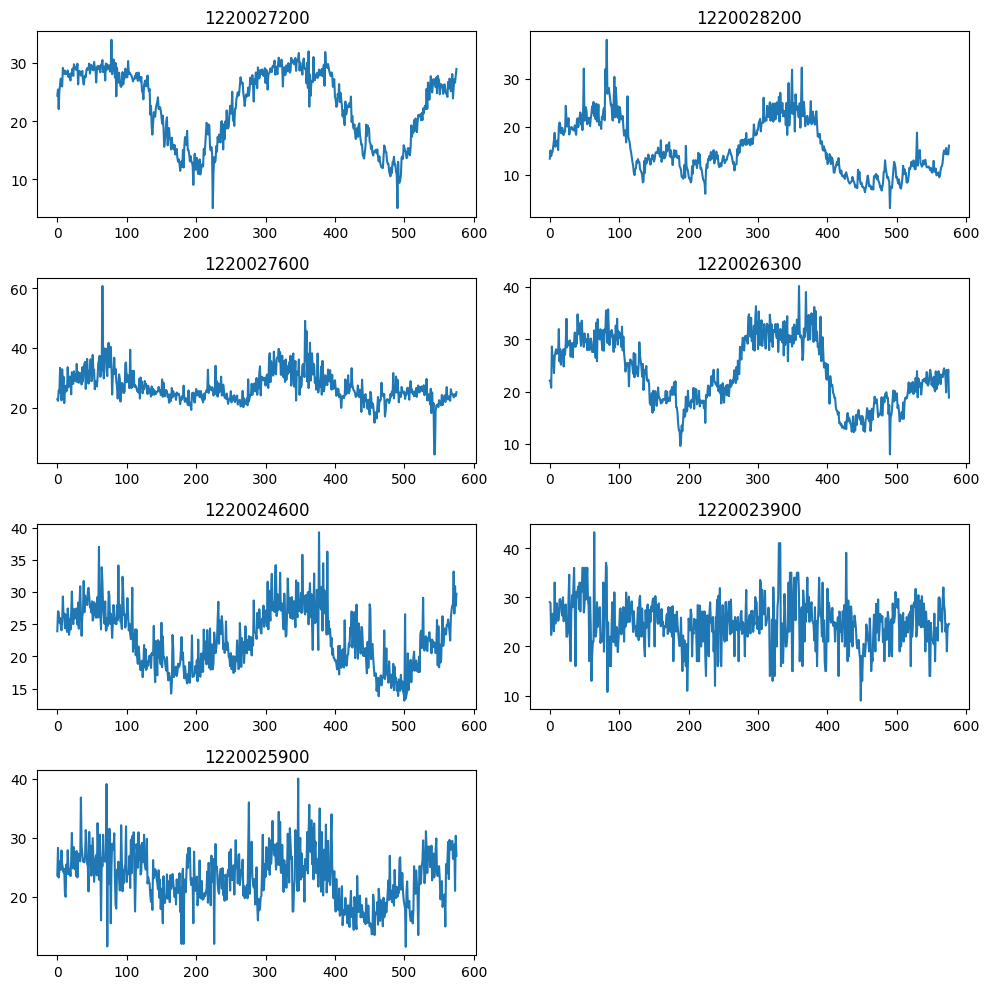

In [8]:
plt.figure(figsize=(10,10))

plt.subplot(4, 2, 1)
plt.title('1220027200')
plt.plot(df['1220027200'].values[-576:])

plt.subplot(4, 2, 2)
plt.title('1220028200')
plt.plot(df['1220028200'].values[-576:])

plt.subplot(4, 2, 3)
plt.title('1220027600')
plt.plot(df['1220027600'].values[-576:])

plt.subplot(4, 2, 4)
plt.title('1220026300')
plt.plot(df['1220026300'].values[-576:])

plt.subplot(4, 2, 5)
plt.title('1220024600')
plt.plot(df['1220024600'].values[-576:])

plt.subplot(4, 2, 6)
plt.title('1220023900')
plt.plot(df['1220023900'].values[-576:])

plt.subplot(4, 2, 7)
plt.title('1220025900')
plt.plot(df['1220025900'].values[-576:])

plt.tight_layout()

### 0%

In [9]:
supervisor = get_supervisor('data/yamls/0per.yaml', 'models/0per/epo37.tar')
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/0per')
evaluation(y_pred, y_true)

2023-08-21 20:44:05,956 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821204405/


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_140552\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


2023-08-21 20:44:07,095 - INFO - Model created
2
15 Min
MAE: tensor(2.0251) RMSE: tensor(2.9248) MAPE: 8.651766953644929 MAPE2: tensor(8.6518)
5
30 Min
MAE: tensor(2.3559) RMSE: tensor(3.2787) MAPE: 10.05798269201208 MAPE2: tensor(10.0580)
8
45 Min
MAE: tensor(2.6220) RMSE: tensor(3.5662) MAPE: 11.152189749258536 MAPE2: tensor(11.1522)
11
60 Min
MAE: tensor(2.8945) RMSE: tensor(3.8527) MAPE: 12.275628690366391 MAPE2: tensor(12.2756)


In [10]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(y_pred[i][:36])
    y_truth.append(y_true[i][:36])
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(1.8285) RMSE: tensor(2.5328) MAPE: 6.963241247483241 MAPE2: tensor(6.9632)
5
30 Min
MAE: tensor(2.1520) RMSE: tensor(2.9681) MAPE: 8.069877859986859 MAPE2: tensor(8.0699)
8
45 Min
MAE: tensor(2.4002) RMSE: tensor(3.2933) MAPE: 8.951682220270603 MAPE2: tensor(8.9517)
11
60 Min
MAE: tensor(2.5638) RMSE: tensor(3.4550) MAPE: 9.491294696007246 MAPE2: tensor(9.4913)


### 5%

In [11]:
supervisor = get_supervisor('data/yamls/5per.yaml', 'models/5per/epo64.tar')
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/5per')
evaluation(y_pred, y_true)

2023-08-21 20:48:18,489 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821204818/
2023-08-21 20:48:18,489 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821204818/
2023-08-21 20:48:18,620 - INFO - Model created
2023-08-21 20:48:18,620 - INFO - Model created


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_140552\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


2
15 Min
MAE: tensor(2.0954) RMSE: tensor(3.0210) MAPE: 8.81402333577474 MAPE2: tensor(8.8140)
5
30 Min
MAE: tensor(2.3896) RMSE: tensor(3.3161) MAPE: 10.064478677416606 MAPE2: tensor(10.0645)
8
45 Min
MAE: tensor(2.6097) RMSE: tensor(3.5534) MAPE: 11.009401593889509 MAPE2: tensor(11.0094)
11
60 Min
MAE: tensor(2.7986) RMSE: tensor(3.7328) MAPE: 11.807201324947297 MAPE2: tensor(11.8072)


In [12]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(y_pred[i][:34])
    y_truth.append(y_true[i][:34])
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(1.8124) RMSE: tensor(2.5072) MAPE: 6.837488382804294 MAPE2: tensor(6.8375)
5
30 Min
MAE: tensor(2.0592) RMSE: tensor(2.8015) MAPE: 7.7576452944459025 MAPE2: tensor(7.7576)
8
45 Min
MAE: tensor(2.2222) RMSE: tensor(3.0194) MAPE: 8.288831310111936 MAPE2: tensor(8.2888)
11
60 Min
MAE: tensor(2.3592) RMSE: tensor(3.2071) MAPE: 8.830957492860424 MAPE2: tensor(8.8310)


In [13]:
for i in range(12):
    y_pred[i] = np.concatenate((y_pred[i], np.zeros((576, 2))), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220028200'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220025900'].values[-576:].reshape(-1, 1)), axis=1)
    
evaluation(y_pred, y_true)

2
15 Min
MAE: tensor(2.5771, dtype=torch.float64) RMSE: tensor(4.5298, dtype=torch.float64) MAPE: 11.346966983010136 MAPE2: tensor(11.3470)
5
30 Min
MAE: tensor(2.8631, dtype=torch.float64) RMSE: tensor(4.7263, dtype=torch.float64) MAPE: 12.562687650648224 MAPE2: tensor(12.5627)
8
45 Min
MAE: tensor(3.0772, dtype=torch.float64) RMSE: tensor(4.8910, dtype=torch.float64) MAPE: 13.481363329356094 MAPE2: tensor(13.4814)
11
60 Min
MAE: tensor(3.2608, dtype=torch.float64) RMSE: tensor(5.0193, dtype=torch.float64) MAPE: 14.257001373713146 MAPE2: tensor(14.2570)


In [14]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(np.concatenate((y_pred[i][:34], y_pred[i][-2].reshape(1, -1)), axis=0))
    y_truth.append(np.concatenate((y_true[i][:34], y_true[i][-2].reshape(1, -1)), axis=0))
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(2.3734, dtype=torch.float64) RMSE: tensor(4.4630, dtype=torch.float64) MAPE: 9.438843398736989 MAPE2: tensor(9.4388)
5
30 Min
MAE: tensor(2.6109, dtype=torch.float64) RMSE: tensor(4.6277, dtype=torch.float64) MAPE: 10.322386477025796 MAPE2: tensor(10.3224)
8
45 Min
MAE: tensor(2.7618, dtype=torch.float64) RMSE: tensor(4.7544, dtype=torch.float64) MAPE: 10.81826277133413 MAPE2: tensor(10.8183)
11
60 Min
MAE: tensor(2.9040, dtype=torch.float64) RMSE: tensor(4.8757, dtype=torch.float64) MAPE: 11.36746382451164 MAPE2: tensor(11.3675)


In [15]:
drop_df = pd.read_csv('../Missing Data/5per_feature.csv').drop(columns = ['Unnamed: 0'])
drop_df

,1220027200,1220028300,1220026200,1220029700,1220029100,1220027400,1220029900,1220029000,1220030100,1220027600,...,007002,007003,008000,008001,008002,008003,009000,009001,009002,009003
0,26.81,21.90,30.22,25.19,28.65,30.79,28.18,26.37,19.00,30.21,...,28.805,29.395,28.275,26.445,30.905,29.075,29.080000,29.080000,27.120,33.570
1,29.64,19.84,27.00,26.96,31.06,30.52,31.57,22.31,24.67,28.40,...,25.410,29.355,33.770,30.400,34.810,31.440,34.500000,34.500000,35.750,32.750
2,28.94,20.95,32.49,26.20,31.83,27.82,31.39,19.00,23.85,21.67,...,25.210,27.875,31.320,29.335,30.640,28.655,27.320000,27.320000,27.720,28.555
3,28.41,20.36,30.44,26.72,29.19,32.74,29.39,24.60,27.85,29.12,...,27.100,28.180,31.750,27.220,34.080,29.550,27.400000,27.400000,29.100,28.625
4,30.29,20.47,30.82,27.21,33.13,29.08,27.15,23.87,26.02,35.07,...,20.920,26.090,28.510,29.510,31.365,32.365,26.596667,26.596667,24.395,31.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,25.78,23.89,33.47,25.93,23.16,21.88,37.42,24.97,22.07,23.40,...,25.865,32.045,25.620,24.880,33.115,32.375,31.106667,31.106667,29.785,33.700
2876,27.20,23.04,33.22,28.45,25.27,23.90,36.46,24.42,20.99,23.83,...,26.540,27.590,26.015,21.405,30.585,25.975,27.106667,27.106667,28.390,27.280
2877,26.61,26.83,33.90,25.24,23.24,24.18,34.65,26.05,21.49,24.52,...,31.715,30.045,24.870,24.240,32.620,31.990,26.826667,26.826667,31.240,26.760
2878,27.83,28.97,31.51,28.05,26.31,25.17,32.84,25.08,21.82,23.85,...,29.170,30.095,32.400,29.190,35.075,31.865,29.926667,29.926667,31.120,31.950


In [16]:
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/5per')

In [17]:
print(np.where(drop_df.columns == '002000'), np.where(drop_df.columns == '002002'))
print(np.where(drop_df.columns == '009000'), np.where(drop_df.columns == '009001'))

(array([38], dtype=int64),) (array([40], dtype=int64),)
(array([66], dtype=int64),) (array([67], dtype=int64),)


In [18]:
print(np.where(df.columns == '1220028200'), np.where(df.columns == '1220025900'))

(array([4], dtype=int64),) (array([35], dtype=int64),)


In [19]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(np.concatenate((y_pred[i], 
                       ((y_pred[i][:, 38] + y_pred[i][:, 40]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 66] + y_pred[i][:, 67]) / 2).reshape(-1, 1)), axis=1))
    
    y_truth.append(np.concatenate((y_true[i], 
                        df['1220028200'].values[-576:].reshape(-1, 1),
                        df['1220025900'].values[-576:].reshape(-1, 1)), axis=1))
    
evaluation(y_preds, y_truth)

for i in range(12):
    y_preds[i] = y_preds[i][:, :36]
    y_truth[i] = y_truth[i][:, :36]
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(2.2396, dtype=torch.float64) RMSE: tensor(3.3043, dtype=torch.float64) MAPE: 9.99154888446224 MAPE2: tensor(9.9915)
5
30 Min
MAE: tensor(2.5268, dtype=torch.float64) RMSE: tensor(3.5690, dtype=torch.float64) MAPE: 11.211281214519772 MAPE2: tensor(11.2113)
8
45 Min
MAE: tensor(2.7392, dtype=torch.float64) RMSE: tensor(3.7801, dtype=torch.float64) MAPE: 12.119597182313065 MAPE2: tensor(12.1196)
11
60 Min
MAE: tensor(2.9235, dtype=torch.float64) RMSE: tensor(3.9432, dtype=torch.float64) MAPE: 12.89246997735963 MAPE2: tensor(12.8925)
2
15 Min
MAE: tensor(2.3300, dtype=torch.float64) RMSE: tensor(3.4031, dtype=torch.float64) MAPE: 9.953400657712477 MAPE2: tensor(9.9534)
5
30 Min
MAE: tensor(2.6423, dtype=torch.float64) RMSE: tensor(3.7137, dtype=torch.float64) MAPE: 11.296895391152562 MAPE2: tensor(11.2969)
8
45 Min
MAE: tensor(2.8801, dtype=torch.float64) RMSE: tensor(3.9675, dtype=torch.float64) MAPE: 12.315924181476138 MAPE2: tensor(12.3159)
11
60 Min
MAE: tensor(3.0

In [20]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

7.287192909055285 8.02718903416076 0.5122092068195343


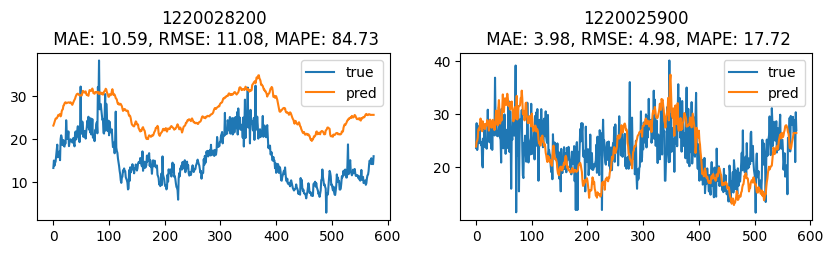

In [21]:
idx = 0

sim_df = pd.DataFrame(columns=['1220028200_true', '1220025900_true',
                               '1220028200_pred', '1220025900_pred'])

sim_df['1220028200_true'] = df['1220028200'].values[-576:]
sim_df['1220025900_true'] = df['1220025900'].values[-576:]

sim_df['1220028200_pred'] = (y_pred[idx][:, 38] + y_pred[idx][:, 40]) / 2
sim_df['1220025900_pred'] = (y_pred[idx][:, 66] + y_pred[idx][:, 67]) / 2

maes = []
rmses = []
mapes = []

plt.figure(figsize=(10,10))

plt.subplot(4, 2, 1)
mae, rmse, mape = missing_eval(sim_df['1220028200_pred'].values, sim_df['1220028200_true'].values)
plt.title('1220028200' + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                         ', MAPE: ' + str(round(mape * 100, 2)))
plt.plot(sim_df['1220028200_true'], label='true')
plt.plot(sim_df['1220028200_pred'], label='pred')
plt.legend()

maes.append(mae)
rmses.append(rmse)
mapes.append(mape)

plt.subplot(4, 2, 2)
mae, rmse, mape = missing_eval(sim_df['1220025900_pred'].values, sim_df['1220025900_true'].values)
plt.title('1220025900' + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                         ', MAPE: ' + str(round(mape * 100, 2)))
plt.plot(sim_df['1220025900_true'], label='true')
plt.plot(sim_df['1220025900_pred'], label='pred')
plt.legend()

maes.append(mae)
rmses.append(rmse)
mapes.append(mape)

print(np.mean(np.array(maes)), np.mean(np.array(rmses)), np.mean(np.array(mapes)))

### 10%

In [22]:
supervisor = get_supervisor('data/yamls/10per.yaml', 'models/10per/epo30.tar')
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/10per')
evaluation(y_pred, y_true)

2023-08-21 20:55:01,760 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821205501/
2023-08-21 20:55:01,760 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821205501/
2023-08-21 20:55:01,760 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821205501/
2023-08-21 20:55:01,852 - INFO - Model created
2023-08-21 20:55:01,852 - INFO - Model created
2023-08-21 20:55:01,852 - INFO - Model created


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_140552\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


2
15 Min
MAE: tensor(1.9384) RMSE: tensor(2.8046) MAPE: 8.252770292992686 MAPE2: tensor(8.2528)
5
30 Min
MAE: tensor(2.1918) RMSE: tensor(3.0887) MAPE: 9.274935254863664 MAPE2: tensor(9.2749)
8
45 Min
MAE: tensor(2.4045) RMSE: tensor(3.3146) MAPE: 10.09772930269927 MAPE2: tensor(10.0977)
11
60 Min
MAE: tensor(2.6072) RMSE: tensor(3.5201) MAPE: 10.895867441214767 MAPE2: tensor(10.8959)


In [23]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(y_pred[i][:32])
    y_truth.append(y_true[i][:32])
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(1.7483) RMSE: tensor(2.4119) MAPE: 6.663649222430061 MAPE2: tensor(6.6637)
5
30 Min
MAE: tensor(2.0084) RMSE: tensor(2.7750) MAPE: 7.616782188415527 MAPE2: tensor(7.6168)
8
45 Min
MAE: tensor(2.1959) RMSE: tensor(3.0076) MAPE: 8.217371211332432 MAPE2: tensor(8.2174)
11
60 Min
MAE: tensor(2.2575) RMSE: tensor(3.0650) MAPE: 8.444971196791705 MAPE2: tensor(8.4450)


In [24]:
for i in range(12):
    y_pred[i] = np.concatenate((y_pred[i], np.zeros((576, 4))), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220028200'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220024600'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220023900'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220025900'].values[-576:].reshape(-1, 1)), axis=1)
    
evaluation(y_pred, y_true)

2
15 Min
MAE: tensor(3.0336, dtype=torch.float64) RMSE: tensor(5.9628, dtype=torch.float64) MAPE: 13.34983880190398 MAPE2: tensor(13.3498)
5
30 Min
MAE: tensor(3.2730, dtype=torch.float64) RMSE: tensor(6.0940, dtype=torch.float64) MAPE: 14.315216240002805 MAPE2: tensor(14.3152)
8
45 Min
MAE: tensor(3.4739, dtype=torch.float64) RMSE: tensor(6.2051, dtype=torch.float64) MAPE: 15.092300108873905 MAPE2: tensor(15.0923)
11
60 Min
MAE: tensor(3.6653, dtype=torch.float64) RMSE: tensor(6.3111, dtype=torch.float64) MAPE: 15.846097253753152 MAPE2: tensor(15.8461)


In [25]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(np.concatenate((y_pred[i][:32], y_pred[i][-4].reshape(1, -1)), axis=0))
    y_truth.append(np.concatenate((y_true[i][:32], y_true[i][-4].reshape(1, -1)), axis=0))
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(2.9831, dtype=torch.float64) RMSE: tensor(6.1945, dtype=torch.float64) MAPE: 11.851350414716263 MAPE2: tensor(11.8513)
5
30 Min
MAE: tensor(3.2082, dtype=torch.float64) RMSE: tensor(6.3263, dtype=torch.float64) MAPE: 12.680848279974702 MAPE2: tensor(12.6808)
8
45 Min
MAE: tensor(3.3856, dtype=torch.float64) RMSE: tensor(6.4247, dtype=torch.float64) MAPE: 13.24626192786548 MAPE2: tensor(13.2463)
11
60 Min
MAE: tensor(3.4551, dtype=torch.float64) RMSE: tensor(6.4547, dtype=torch.float64) MAPE: 13.497090640092543 MAPE2: tensor(13.4971)


In [26]:
drop_df = pd.read_csv('../Missing Data/10per_feature.csv').drop(columns = ['Unnamed: 0'])
drop_df

,1220027200,1220028300,1220026200,1220029700,1220029100,1220027400,1220029900,1220029000,1220030100,1220027600,...,007002,007003,008000,008001,008002,008003,009000,009001,009002,009003
0,26.81,21.90,30.22,25.19,28.65,30.79,28.18,26.37,19.00,30.21,...,28.805,29.395,28.275,29.230000,30.905,29.230000,29.080000,29.080000,27.120,33.570
1,29.64,19.84,27.00,26.96,31.06,30.52,31.57,22.31,24.67,28.40,...,25.410,29.355,33.770,33.070000,34.810,33.070000,34.500000,34.500000,35.750,32.750
2,28.94,20.95,32.49,26.20,31.83,27.82,31.39,19.00,23.85,21.67,...,25.210,27.875,31.320,31.046667,30.640,31.046667,27.320000,27.320000,27.720,28.555
3,28.41,20.36,30.44,26.72,29.19,32.74,29.39,24.60,27.85,29.12,...,27.100,28.180,31.750,31.200000,34.080,31.200000,27.400000,27.400000,29.100,28.625
4,30.29,20.47,30.82,27.21,33.13,29.08,27.15,23.87,26.02,35.07,...,20.920,26.090,28.510,30.250000,31.365,30.250000,26.596667,26.596667,24.395,31.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,25.78,23.89,33.47,25.93,23.16,21.88,37.42,24.97,22.07,23.40,...,25.865,32.045,25.620,30.490000,33.115,30.490000,31.106667,31.106667,29.785,33.700
2876,27.20,23.04,33.22,28.45,25.27,23.90,36.46,24.42,20.99,23.83,...,26.540,27.590,26.015,28.326667,30.585,28.326667,27.106667,27.106667,28.390,27.280
2877,26.61,26.83,33.90,25.24,23.24,24.18,34.65,26.05,21.49,24.52,...,31.715,30.045,24.870,29.993333,32.620,29.993333,26.826667,26.826667,31.240,26.760
2878,27.83,28.97,31.51,28.05,26.31,25.17,32.84,25.08,21.82,23.85,...,29.170,30.095,32.400,34.696667,35.075,34.696667,29.926667,29.926667,31.120,31.950


In [27]:
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/10per')

In [28]:
print(np.where(drop_df.columns == '002000'), np.where(drop_df.columns == '002002'))
print(np.where(drop_df.columns == '005002'), np.where(drop_df.columns == '005003'))
print(np.where(drop_df.columns == '008001'), np.where(drop_df.columns == '008003'))
print(np.where(drop_df.columns == '009000'), np.where(drop_df.columns == '009001'))

(array([36], dtype=int64),) (array([38], dtype=int64),)
(array([50], dtype=int64),) (array([51], dtype=int64),)
(array([61], dtype=int64),) (array([63], dtype=int64),)
(array([64], dtype=int64),) (array([65], dtype=int64),)


In [29]:
print(np.where(df.columns == '1220028200'), np.where(df.columns == '1220024600'))
print(np.where(df.columns == '1220023900'), np.where(df.columns == '1220025900'))

(array([4], dtype=int64),) (array([18], dtype=int64),)
(array([29], dtype=int64),) (array([35], dtype=int64),)


In [31]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(np.concatenate((y_pred[i], 
                       ((y_pred[i][:, 36] + y_pred[i][:, 38]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 50] + y_pred[i][:, 51]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 61] + y_pred[i][:, 63]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 64] + y_pred[i][:, 65]) / 2).reshape(-1, 1)), axis=1))
    
    y_truth.append(np.concatenate((y_true[i], 
                        df['1220028200'].values[-576:].reshape(-1, 1),
                        df['1220024600'].values[-576:].reshape(-1, 1),
                        df['1220023900'].values[-576:].reshape(-1, 1),
                        df['1220025900'].values[-576:].reshape(-1, 1)), axis=1))
    
evaluation(y_preds, y_truth)

for i in range(12):
    y_preds[i] = y_preds[i][:, :36]
    y_truth[i] = y_truth[i][:, :36]
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(2.1529, dtype=torch.float64) RMSE: tensor(3.2122, dtype=torch.float64) MAPE: 9.792554801267702 MAPE2: tensor(9.7926)
5
30 Min
MAE: tensor(2.3888, dtype=torch.float64) RMSE: tensor(3.4361, dtype=torch.float64) MAPE: 10.720630959486423 MAPE2: tensor(10.7206)
8
45 Min
MAE: tensor(2.5865, dtype=torch.float64) RMSE: tensor(3.6176, dtype=torch.float64) MAPE: 11.462863803081705 MAPE2: tensor(11.4629)
11
60 Min
MAE: tensor(2.7765, dtype=torch.float64) RMSE: tensor(3.7905, dtype=torch.float64) MAPE: 12.193432237019358 MAPE2: tensor(12.1934)
2
15 Min
MAE: tensor(2.1391, dtype=torch.float64) RMSE: tensor(3.1319, dtype=torch.float64) MAPE: 9.244531548384552 MAPE2: tensor(9.2445)
5
30 Min
MAE: tensor(2.4207, dtype=torch.float64) RMSE: tensor(3.4373, dtype=torch.float64) MAPE: 10.392288512350255 MAPE2: tensor(10.3923)
8
45 Min
MAE: tensor(2.6335, dtype=torch.float64) RMSE: tensor(3.6681, dtype=torch.float64) MAPE: 11.214598185042162 MAPE2: tensor(11.2146)
11
60 Min
MAE: tensor(2

5.7988279268311125 6.686617364829937 0.3609057776629925


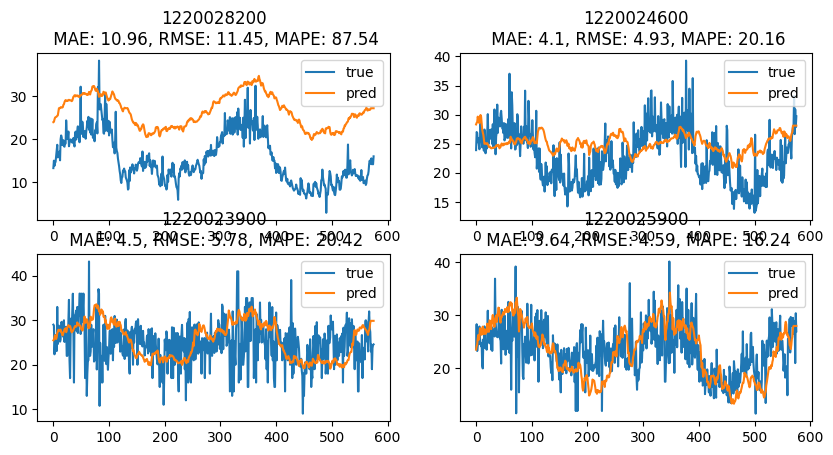

In [32]:
idx = 0

sim_df = pd.DataFrame(columns=['1220028200_true', '1220024600_true',
                               '1220023900_true', '1220025900_true',
                               '1220028200_pred', '1220024600_pred',
                               '1220023900_pred', '1220025900_pred'])

sim_df['1220028200_true'] = df['1220028200'].values[-576:]
sim_df['1220024600_true'] = df['1220024600'].values[-576:]
sim_df['1220023900_true'] = df['1220023900'].values[-576:]
sim_df['1220025900_true'] = df['1220025900'].values[-576:]

sim_df['1220028200_pred'] = (y_pred[idx][:, 36] + y_pred[idx][:, 38]) / 2
sim_df['1220024600_pred'] = (y_pred[idx][:, 50] + y_pred[idx][:, 51]) / 2
sim_df['1220023900_pred'] = (y_pred[idx][:, 61] + y_pred[idx][:, 63]) / 2
sim_df['1220025900_pred'] = (y_pred[idx][:, 64] + y_pred[idx][:, 65]) / 2

maes = []
rmses = []
mapes = []

plt.figure(figsize=(10,10))

plt.subplot(4, 2, 1)
mae, rmse, mape = missing_eval(sim_df['1220028200_pred'].values, sim_df['1220028200_true'].values)
plt.title('1220028200' + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                         ', MAPE: ' + str(round(mape * 100, 2)))
plt.plot(sim_df['1220028200_true'], label='true')
plt.plot(sim_df['1220028200_pred'], label='pred')
plt.legend()

maes.append(mae)
rmses.append(rmse)
mapes.append(mape)

plt.subplot(4, 2, 2)
mae, rmse, mape = missing_eval(sim_df['1220024600_pred'].values, sim_df['1220024600_true'].values)
plt.title('1220024600' + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                         ', MAPE: ' + str(round(mape * 100, 2)))
plt.plot(sim_df['1220024600_true'], label='true')
plt.plot(sim_df['1220024600_pred'], label='pred')
plt.legend()

maes.append(mae)
rmses.append(rmse)
mapes.append(mape)

plt.subplot(4, 2, 3)
mae, rmse, mape = missing_eval(sim_df['1220023900_pred'].values, sim_df['1220023900_true'].values)
plt.title('1220023900' + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                         ', MAPE: ' + str(round(mape * 100, 2)))
plt.plot(sim_df['1220023900_true'], label='true')
plt.plot(sim_df['1220023900_pred'], label='pred')
plt.legend()

maes.append(mae)
rmses.append(rmse)
mapes.append(mape)

plt.subplot(4, 2, 4)
mae, rmse, mape = missing_eval(sim_df['1220025900_pred'].values, sim_df['1220025900_true'].values)
plt.title('1220025900' + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                         ', MAPE: ' + str(round(mape * 100, 2)))
plt.plot(sim_df['1220025900_true'], label='true')
plt.plot(sim_df['1220025900_pred'], label='pred')
plt.legend()

maes.append(mae)
rmses.append(rmse)
mapes.append(mape)

print(np.mean(np.array(maes)), np.mean(np.array(rmses)), np.mean(np.array(mapes)))

### 20%

In [51]:
supervisor = get_supervisor('data/yamls/20per.yaml', 'models/20per/epo5.tar')
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/20per')
evaluation(y_pred, y_true)

2023-08-21 21:30:56,911 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821213056/
2023-08-21 21:30:56,911 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821213056/
2023-08-21 21:30:56,911 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821213056/
2023-08-21 21:30:56,911 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821213056/
2023-08-21 21:30:56,911 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821213056/
2023-08-21 21:30:56,911 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821213056/
2023-08-21 21:30:56,911 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0821213056/
2023-08-21 21:30:57,007 - INFO - Model created
2023-08-21 21:30:57,007 - INFO - Model created
2023-08-21 21:30:57,007 - INFO - Model created
2023-08-21 21:30:57,007 - INFO - Model created
2023-08-21 21:30:57,007 - INFO - Model created
2023-08-21 21:30

C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_140552\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


2
15 Min
MAE: tensor(1.9176) RMSE: tensor(2.8059) MAPE: 7.985483805338542 MAPE2: tensor(7.9855)
5
30 Min
MAE: tensor(2.1937) RMSE: tensor(3.0933) MAPE: 9.132098336505075 MAPE2: tensor(9.1321)
8
45 Min
MAE: tensor(2.4394) RMSE: tensor(3.3546) MAPE: 10.113274337898972 MAPE2: tensor(10.1133)
11
60 Min
MAE: tensor(2.7028) RMSE: tensor(3.6303) MAPE: 11.159558418469551 MAPE2: tensor(11.1596)


In [52]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(y_pred[i][:29])
    y_truth.append(y_true[i][:29])
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(1.6648) RMSE: tensor(2.3228) MAPE: 6.315475180547497 MAPE2: tensor(6.3155)
5
30 Min
MAE: tensor(1.9811) RMSE: tensor(2.6741) MAPE: 7.4677549812458555 MAPE2: tensor(7.4678)
8
45 Min
MAE: tensor(2.2036) RMSE: tensor(2.9817) MAPE: 8.203398605872843 MAPE2: tensor(8.2034)
11
60 Min
MAE: tensor(2.4736) RMSE: tensor(3.3220) MAPE: 9.045899894572695 MAPE2: tensor(9.0459)


In [54]:
for i in range(12):
    y_pred[i] = np.concatenate((y_pred[i], np.zeros((576, 7))), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220027200'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220028200'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220027600'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220026300'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220024600'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220023900'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220025900'].values[-576:].reshape(-1, 1)), axis=1)
    
evaluation(y_pred, y_true)

2
15 Min
MAE: tensor(3.9538, dtype=torch.float64) RMSE: tensor(7.8588, dtype=torch.float64) MAPE: 16.931339598146238 MAPE2: tensor(16.9313)
5
30 Min
MAE: tensor(4.2031, dtype=torch.float64) RMSE: tensor(7.9556, dtype=torch.float64) MAPE: 17.966477832023795 MAPE2: tensor(17.9665)
8
45 Min
MAE: tensor(4.4249, dtype=torch.float64) RMSE: tensor(8.0506, dtype=torch.float64) MAPE: 18.852261528585533 MAPE2: tensor(18.8523)
11
60 Min
MAE: tensor(4.6627, dtype=torch.float64) RMSE: tensor(8.1579, dtype=torch.float64) MAPE: 19.7968233593378 MAPE2: tensor(19.7968)


In [55]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(np.concatenate((y_pred[i][:29], y_pred[i][-7].reshape(1, -1)), axis=0))
    y_truth.append(np.concatenate((y_true[i][:29], y_true[i][-7].reshape(1, -1)), axis=0))
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(3.9946, dtype=torch.float64) RMSE: tensor(8.3693, dtype=torch.float64) MAPE: 15.430439606484207 MAPE2: tensor(15.4304)
5
30 Min
MAE: tensor(4.2681, dtype=torch.float64) RMSE: tensor(8.4585, dtype=torch.float64) MAPE: 16.438240401424512 MAPE2: tensor(16.4382)
8
45 Min
MAE: tensor(4.4862, dtype=torch.float64) RMSE: tensor(8.5600, dtype=torch.float64) MAPE: 17.141362165833865 MAPE2: tensor(17.1414)
11
60 Min
MAE: tensor(4.7348, dtype=torch.float64) RMSE: tensor(8.6713, dtype=torch.float64) MAPE: 17.92180241194347 MAPE2: tensor(17.9218)


In [56]:
drop_df = pd.read_csv('../Missing Data/20per_feature.csv').drop(columns = ['Unnamed: 0'])
drop_df

,1220028300,1220026200,1220029700,1220029100,1220027400,1220029900,1220029000,1220030100,1220031100,1220024000,...,007002,007003,008000,008001,008002,008003,009000,009001,009002,009003
0,21.90,30.22,25.19,28.65,30.79,28.18,26.37,19.00,36.00,28.25,...,28.805,29.395,28.275,29.230000,30.905,29.230000,29.080000,29.080000,27.120,33.570
1,19.84,27.00,26.96,31.06,30.52,31.57,22.31,24.67,29.42,28.19,...,25.410,29.355,33.770,33.070000,34.810,33.070000,34.500000,34.500000,35.750,32.750
2,20.95,32.49,26.20,31.83,27.82,31.39,19.00,23.85,28.28,34.48,...,25.210,27.875,31.320,31.046667,30.640,31.046667,27.320000,27.320000,27.720,28.555
3,20.36,30.44,26.72,29.19,32.74,29.39,24.60,27.85,32.91,37.51,...,27.100,28.180,31.750,31.200000,34.080,31.200000,27.400000,27.400000,29.100,28.625
4,20.47,30.82,27.21,33.13,29.08,27.15,23.87,26.02,28.64,32.38,...,20.920,26.090,28.510,30.250000,31.365,30.250000,26.596667,26.596667,24.395,31.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,23.89,33.47,25.93,23.16,21.88,37.42,24.97,22.07,25.35,33.36,...,25.865,32.045,25.620,30.490000,33.115,30.490000,31.106667,31.106667,29.785,33.700
2876,23.04,33.22,28.45,25.27,23.90,36.46,24.42,20.99,24.62,29.39,...,26.540,27.590,26.015,28.326667,30.585,28.326667,27.106667,27.106667,28.390,27.280
2877,26.83,33.90,25.24,23.24,24.18,34.65,26.05,21.49,26.85,27.23,...,31.715,30.045,24.870,29.993333,32.620,29.993333,26.826667,26.826667,31.240,26.760
2878,28.97,31.51,28.05,26.31,25.17,32.84,25.08,21.82,24.98,30.79,...,29.170,30.095,32.400,34.696667,35.075,34.696667,29.926667,29.926667,31.120,31.950


In [57]:
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/20per')

In [58]:
print(np.where(drop_df.columns == '001000'), np.where(drop_df.columns == '001002'))
print(np.where(drop_df.columns == '002000'), np.where(drop_df.columns == '002002'))
print(np.where(drop_df.columns == '003002'), np.where(drop_df.columns == '003003'))
print(np.where(drop_df.columns == '004000'), np.where(drop_df.columns == '004001'))
print(np.where(drop_df.columns == '005002'), np.where(drop_df.columns == '005003'))
print(np.where(drop_df.columns == '008001'), np.where(drop_df.columns == '008003'))
print(np.where(drop_df.columns == '009000'), np.where(drop_df.columns == '009001'))

(array([29], dtype=int64),) (array([31], dtype=int64),)
(array([33], dtype=int64),) (array([35], dtype=int64),)
(array([39], dtype=int64),) (array([40], dtype=int64),)
(array([41], dtype=int64),) (array([42], dtype=int64),)
(array([47], dtype=int64),) (array([48], dtype=int64),)
(array([58], dtype=int64),) (array([60], dtype=int64),)
(array([61], dtype=int64),) (array([62], dtype=int64),)


In [59]:
print(np.where(df.columns == '1220027200'), np.where(df.columns == '1220028200'))
print(np.where(df.columns == '1220027600'), np.where(df.columns == '1220026300'))
print(np.where(df.columns == '1220024600'), np.where(df.columns == '1220023900'), 
      np.where(df.columns == '1220025900'))

(array([0], dtype=int64),) (array([4], dtype=int64),)
(array([10], dtype=int64),) (array([15], dtype=int64),)
(array([18], dtype=int64),) (array([29], dtype=int64),) (array([35], dtype=int64),)


In [60]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(np.concatenate((y_pred[i], 
                       ((y_pred[i][:, 29] + y_pred[i][:, 31]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 33] + y_pred[i][:, 35]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 39] + y_pred[i][:, 40]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 41] + y_pred[i][:, 42]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 47] + y_pred[i][:, 48]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 58] + y_pred[i][:, 60]) / 2).reshape(-1, 1),
                       ((y_pred[i][:, 61] + y_pred[i][:, 62]) / 2).reshape(-1, 1)), axis=1))
    
    y_truth.append(np.concatenate((y_true[i], 
                        df['1220027200'].values[-576:].reshape(-1, 1),
                        df['1220028200'].values[-576:].reshape(-1, 1),
                        df['1220027600'].values[-576:].reshape(-1, 1),
                        df['1220026300'].values[-576:].reshape(-1, 1),
                        df['1220024600'].values[-576:].reshape(-1, 1),
                        df['1220023900'].values[-576:].reshape(-1, 1),
                        df['1220025900'].values[-576:].reshape(-1, 1)), axis=1))
    
evaluation(y_preds, y_truth)

for i in range(12):
    y_preds[i] = y_preds[i][:, :36]
    y_truth[i] = y_truth[i][:, :36]
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(2.2251, dtype=torch.float64) RMSE: tensor(3.3452, dtype=torch.float64) MAPE: 10.056381483907483 MAPE2: tensor(10.0564)
5
30 Min
MAE: tensor(2.4713, dtype=torch.float64) RMSE: tensor(3.5583, dtype=torch.float64) MAPE: 11.058489203122972 MAPE2: tensor(11.0585)
8
45 Min
MAE: tensor(2.6897, dtype=torch.float64) RMSE: tensor(3.7577, dtype=torch.float64) MAPE: 11.909177554684181 MAPE2: tensor(11.9092)
11
60 Min
MAE: tensor(2.9263, dtype=torch.float64) RMSE: tensor(3.9774, dtype=torch.float64) MAPE: 12.824991226917806 MAPE2: tensor(12.8250)
2
15 Min
MAE: tensor(2.0596, dtype=torch.float64) RMSE: tensor(3.0704, dtype=torch.float64) MAPE: 8.63065012828618 MAPE2: tensor(8.6307)
5
30 Min
MAE: tensor(2.3451, dtype=torch.float64) RMSE: tensor(3.3623, dtype=torch.float64) MAPE: 9.806975770146982 MAPE2: tensor(9.8070)
8
45 Min
MAE: tensor(2.5830, dtype=torch.float64) RMSE: tensor(3.6198, dtype=torch.float64) MAPE: 10.732645966484156 MAPE2: tensor(10.7326)
11
60 Min
MAE: tensor(2.

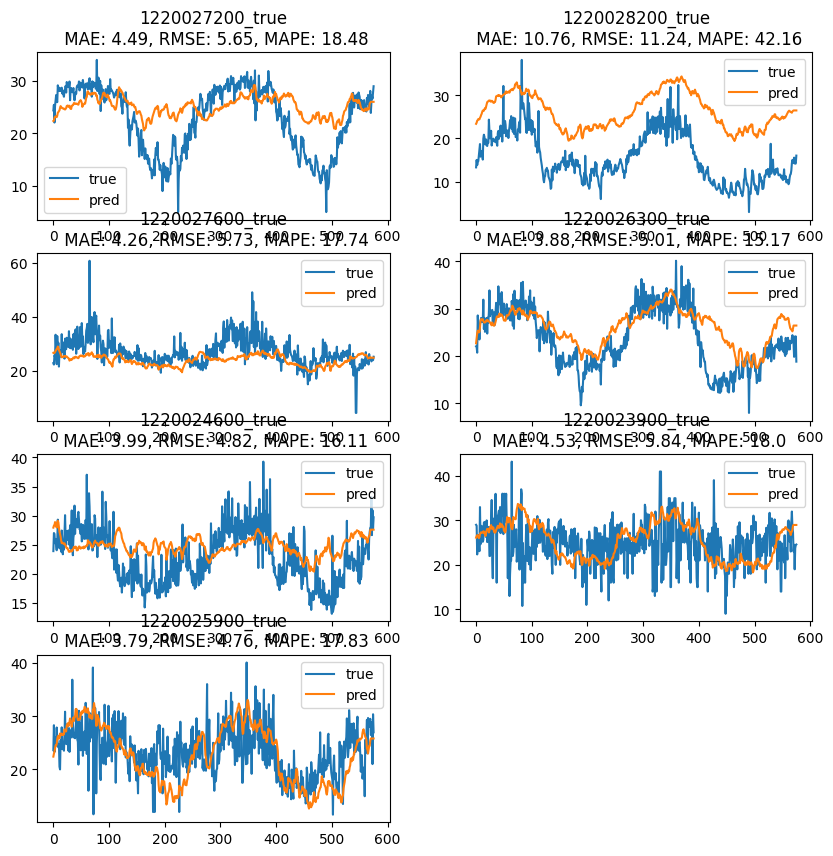

5.101054296701674 6.148438461226667 0.20785691269806453


In [64]:
idx = 0

sim_df = pd.DataFrame(columns=['1220027200_true', '1220028200_true',
                               '1220027600_true', '1220026300_true',
                               '1220024600_true', '1220023900_true',
                               '1220025900_true', '1220027200_pred',
                               '1220028200_pred', '1220027600_pred',
                               '1220026300_pred', '1220024600_pred',
                               '1220023900_pred', '1220025900_pred'])

sim_df['1220027200_true'] = df['1220027200'].values[-576:]
sim_df['1220028200_true'] = df['1220028200'].values[-576:]
sim_df['1220027600_true'] = df['1220027600'].values[-576:]
sim_df['1220026300_true'] = df['1220026300'].values[-576:]
sim_df['1220024600_true'] = df['1220024600'].values[-576:]
sim_df['1220023900_true'] = df['1220023900'].values[-576:]
sim_df['1220025900_true'] = df['1220025900'].values[-576:]

sim_df['1220027200_pred'] = (y_pred[idx][:, 29] + y_pred[idx][:, 31]) / 2
sim_df['1220028200_pred'] = (y_pred[idx][:, 33] + y_pred[idx][:, 35]) / 2
sim_df['1220027600_pred'] = (y_pred[idx][:, 39] + y_pred[idx][:, 40]) / 2
sim_df['1220026300_pred'] = (y_pred[idx][:, 41] + y_pred[idx][:, 42]) / 2
sim_df['1220024600_pred'] = (y_pred[idx][:, 47] + y_pred[idx][:, 48]) / 2
sim_df['1220023900_pred'] = (y_pred[idx][:, 58] + y_pred[idx][:, 60]) / 2
sim_df['1220025900_pred'] = (y_pred[idx][:, 61] + y_pred[idx][:, 62]) / 2

maes = []
rmses = []
mapes = []

plt.figure(figsize=(10,10))

for i in range(7):
    plt.subplot(4, 2, i+1)
    columns = sim_df.columns
    mae, rmse, mape = missing_eval(sim_df[columns[i]].values, sim_df[columns[i+7]].values)
    plt.title(columns[i] + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                         ', MAPE: ' + str(round(mape * 100, 2)))
    plt.plot(sim_df[columns[i]].values, label='true')
    plt.plot(sim_df[columns[i+7]].values, label='pred')
    plt.legend()

    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)

plt.show()

print(np.mean(np.array(maes)), np.mean(np.array(rmses)), np.mean(np.array(mapes)))

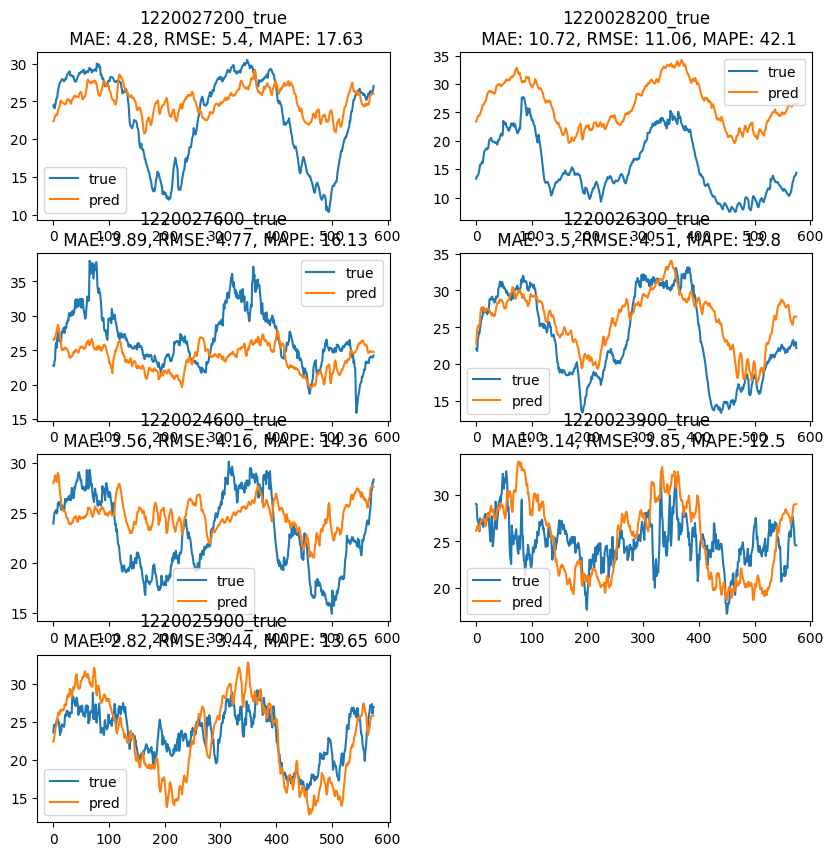

4.559996565914389 5.311409975350315 0.18597683310508728


In [63]:
idx = 0

sim_df = pd.DataFrame(columns=['1220027200_true', '1220028200_true',
                               '1220027600_true', '1220026300_true',
                               '1220024600_true', '1220023900_true',
                               '1220025900_true', '1220027200_pred',
                               '1220028200_pred', '1220027600_pred',
                               '1220026300_pred', '1220024600_pred',
                               '1220023900_pred', '1220025900_pred'])

sim_df['1220027200_true'] = smooth(df['1220027200'].values[-576:], 0.8)
sim_df['1220028200_true'] = smooth(df['1220028200'].values[-576:], 0.8)
sim_df['1220027600_true'] = smooth(df['1220027600'].values[-576:], 0.8)
sim_df['1220026300_true'] = smooth(df['1220026300'].values[-576:], 0.8)
sim_df['1220024600_true'] = smooth(df['1220024600'].values[-576:], 0.8)
sim_df['1220023900_true'] = smooth(df['1220023900'].values[-576:], 0.8)
sim_df['1220025900_true'] = smooth(df['1220025900'].values[-576:], 0.8)

sim_df['1220027200_pred'] = smooth((y_pred[idx][:, 29] + y_pred[idx][:, 31]) / 2, 0.3)
sim_df['1220028200_pred'] = smooth((y_pred[idx][:, 33] + y_pred[idx][:, 35]) / 2, 0.3)
sim_df['1220027600_pred'] = smooth((y_pred[idx][:, 39] + y_pred[idx][:, 40]) / 2, 0.3)
sim_df['1220026300_pred'] = smooth((y_pred[idx][:, 41] + y_pred[idx][:, 42]) / 2, 0.3)
sim_df['1220024600_pred'] = smooth((y_pred[idx][:, 47] + y_pred[idx][:, 48]) / 2, 0.3)
sim_df['1220023900_pred'] = smooth((y_pred[idx][:, 58] + y_pred[idx][:, 60]) / 2, 0.3)
sim_df['1220025900_pred'] = smooth((y_pred[idx][:, 61] + y_pred[idx][:, 62]) / 2, 0.3)

maes = []
rmses = []
mapes = []

plt.figure(figsize=(10,10))

for i in range(7):
    plt.subplot(4, 2, i+1)
    columns = sim_df.columns
    mae, rmse, mape = missing_eval(sim_df[columns[i]].values, sim_df[columns[i+7]].values)
    plt.title(columns[i] + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                         ', MAPE: ' + str(round(mape * 100, 2)))
    plt.plot(sim_df[columns[i]].values, label='true')
    plt.plot(sim_df[columns[i+7]].values, label='pred')
    plt.legend()

    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)

plt.show()

print(np.mean(np.array(maes)), np.mean(np.array(rmses)), np.mean(np.array(mapes)))

In [ ]:
25900 > 23900 > 26300 > 24600 > 27600 > 27200 > 28200